# Traffic Sign Classifier

## Clone the Dataset

In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [2]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [3]:
import pandas as pd
df = pd.read_csv('german-traffic-signs/signnames.csv')
df.head(5)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


## Import necessary Packages

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random 
import pandas as pd
import cv2

Using TensorFlow backend.
/usr/lib/python3.5/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/lib/python3.5/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/lib/python3.5/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/lib/python3.5/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a futur

## Load Train, Test and Validation dataset

In [5]:
np.random.seed(0)
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    valid_data = pickle.load(f)

In [6]:
train_x, train_y = train_data['features'],train_data['labels']
val_x, val_y = valid_data['features'],valid_data['labels']
test_x,test_y = test_data['features'],test_data['labels']

print('Train data shape',train_x.shape,'Train data label',train_y.shape)
print('Test data shape',test_x.shape,'Test data label',test_y.shape)
print('valid data shape',val_x.shape,'Valid data label',val_y.shape)

Train data shape (34799, 32, 32, 3) Train data label (34799,)
Test data shape (12630, 32, 32, 3) Test data label (12630,)
valid data shape (4410, 32, 32, 3) Valid data label (4410,)


## getting number of samples from each class in training dataset

In [7]:
import os
num_samples = []
for i in range(len(df)):
    file_count = len(os.listdir('grstb_data/Train/'+str(i)+'/'))
    num_samples.append(file_count)
print(len(num_samples))

43


In [8]:
print(num_samples)

[210, 2220, 2250, 1410, 1980, 1860, 420, 1440, 1410, 1470, 2010, 1320, 2100, 2160, 780, 630, 420, 1110, 1200, 210, 360, 330, 390, 510, 270, 1500, 600, 240, 540, 270, 450, 780, 240, 689, 420, 1200, 390, 210, 2070, 300, 360, 240, 240]


## Plot the distribution of the number of samples from each class in training dataset

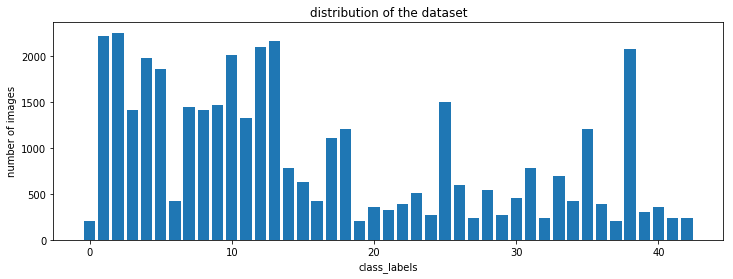

In [9]:
plt.figure(figsize=(12,4))
plt.bar(range(0, len(df)), num_samples)
plt.title('distribution of the dataset')
plt.xlabel('class_labels')
plt.ylabel('number of images')
plt.show()

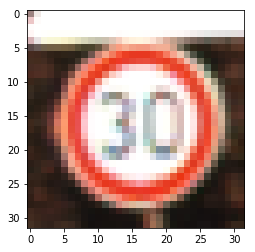

In [10]:
plt.imshow(train_x[3000])

## Convert the image to grayscale
#### Note: Reason to convert to grayscale is, for traffic sign identification, color is not necessary, only edges and shapes are required

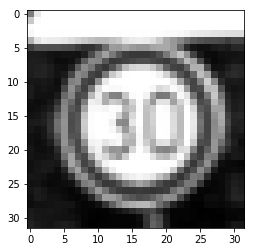

In [11]:
def grayscale(image):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return image

img = grayscale(train_x[3000])
plt.imshow(img, cmap = plt.get_cmap('gray'))

### Use histogram equalization technique to standardize contrast/light in all images

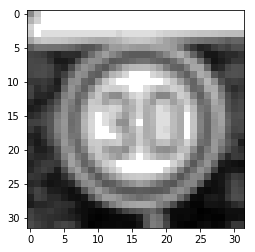

In [12]:
def equalize(image):
    image = cv2.equalizeHist(image)
    return image
img = equalize(img)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [13]:
def processing(image):
    gray_img = grayscale(image)
    img = equalize(gray_img) 
    img = img/255
    return img

## Convert all train, test and validation dataset to grayscale & histogram technique

In [14]:
train_x = np.asarray(list(map(processing, train_x)))
val_x = np.asarray(list(map(processing, val_x)))
test_x = np.asarray(list(map(processing, test_x)))

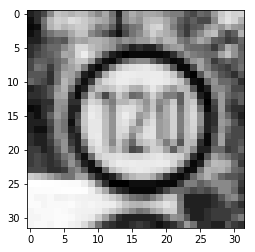

In [15]:
plt.imshow(train_x[random.randint(0, len(train_x-1))],cmap=plt.get_cmap('gray'))

In [16]:
train_x.shape[0]

34799

## Reshape data to 3 dimensional
#### train_x.shape[0] -> number of images
#### train_x.shape[1] -> height
#### train_x.shape[2] -> width
#### 1 -> dimension of the image and 1 denotes grayscale image and for RGB it is 3

In [17]:
train_x = train_x.reshape(train_x.shape[0],train_x.shape[1],train_x.shape[2],1)
val_x = val_x.reshape(val_x.shape[0],val_x.shape[1],val_x.shape[2],1)
test_x = test_x.reshape(test_x.shape[0],test_x.shape[1],test_x.shape[2],1)


## Generate some datasets with different angles using Keras Imagedatagenerator

In [18]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
datagen.fit(train_x)
#batches = datagen.flow(train_x,train_y,batch_size=15)


## One-hot encode the labels

In [19]:
train_y = to_categorical(train_y,43)
test_y = to_categorical(test_y,43)
val_y = to_categorical(val_y,43)

## Define the model

In [20]:
from keras.layers import ReLU
def build_model():
    model = Sequential()
    model.add(Conv2D(60,(5,5),input_shape=(train_x.shape[1],train_x.shape[2],train_x.shape[3])))
    model.add(ReLU())
    model.add(Conv2D(60,(5,5)))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(30,(3,3)))
    model.add(ReLU())
    model.add(Conv2D(30,(3,3)))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(df['ClassId']),activation='softmax'))
    
    model.compile(Adam(lr=0.001), loss="categorical_crossentropy",metrics=["accuracy"])
    return model
    

In [21]:
model = build_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 28, 28, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 24, 24, 60)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
re_lu_3 (ReLU)               (None, 10, 10, 30)        0         
__________

## Train the model

In [22]:
history = model.fit_generator(datagen.flow(train_x,train_y,batch_size=64),
                             steps_per_epoch=150,
                             epochs=15,
                             validation_data=(val_x,val_y),shuffle=1)

Epoch 1/15
150/150 [==============================] - 83s 557ms/step - loss: 3.1492 - acc: 0.1600 - val_loss: 1.8166 - val_acc: 0.4732
Epoch 2/15
150/150 [==============================] - 84s 562ms/step - loss: 1.7783 - acc: 0.4822 - val_loss: 0.7311 - val_acc: 0.7873
Epoch 3/15
150/150 [==============================] - 86s 571ms/step - loss: 1.2033 - acc: 0.6279 - val_loss: 0.4454 - val_acc: 0.8746
Epoch 4/15
150/150 [==============================] - 86s 576ms/step - loss: 0.8660 - acc: 0.7340 - val_loss: 0.2917 - val_acc: 0.9027
Epoch 5/15
150/150 [==============================] - 86s 574ms/step - loss: 0.6928 - acc: 0.7861 - val_loss: 0.2375 - val_acc: 0.9286
Epoch 6/15
150/150 [==============================] - 86s 570ms/step - loss: 0.5895 - acc: 0.8149 - val_loss: 0.1545 - val_acc: 0.9551
Epoch 7/15
150/150 [==============================] - 86s 573ms/step - loss: 0.5202 - acc: 0.8377 - val_loss: 0.1919 - val_acc: 0.9408
Epoch 8/15
150/150 [==============================] - 8

###### able to achieve 92% accuracy

Text(0, 0.5, 'loss')

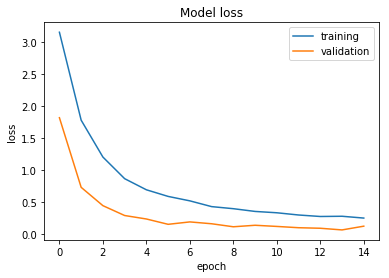

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')

## Evaluate the model with test data

In [31]:
score = model.evaluate(test_x, test_y , verbose = 0)
print("The test score is: ",score[0])
print("The Accuracy score is: ",score[1])

The test score is:  0.15594113600674075
The Accuracy score is:  0.95059382421859


### Testing the model using an external traffic sign image

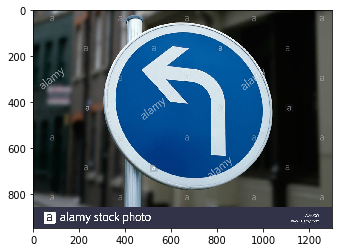

In [35]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img)

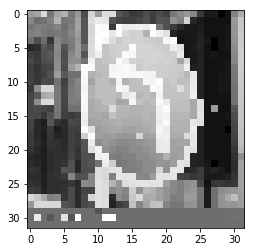

In [36]:
img = np.asarray(img)
img = cv2.resize(img,(32,32))
img = processing(img)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [37]:
df.columns

Index(['ClassId', 'SignName'], dtype='object')

## Finally model predicts the traffic sign correctly

In [45]:
img = img.reshape(1,32,32,1)
label = model.predict_classes(img)
print('Predicted class is ',str(label))
print('The traffic sign is ',df['SignName'][int(label)])

Predicted class is  [34]
The traffic sign is  Turn left ahead
